In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import urllib2
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats
from pandas.stats.api import ols
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
#from matplotlib.pyplot import cm 
import platform
import sys
import glob

import matplotlib as mpl
import matplotlib.cm as cm

import pyproj
from pyproj import Proj
import simplekml

import pyodbc

#import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [20]:
import wellapplication as wa
import UBM

In [21]:
UBM.__version__

'0.0.4'

In [4]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 7
Python Version 2.7.10 (default, May 23 2015, 09:44:00) [MSC v.1500 64 bit (AMD64)]
Pandas Version 0.19.2
Numpy Version 1.12.0
Matplotlib Version 2.0.0
Well Application Version 0.4.19
Scipy Version 0.18.1


In [5]:
import arcpy
arcpy.CheckOutExtension("spatial")
from arcpy import env 
from arcpy.sa import *

In [6]:
engineroute = "H:/Google Drive/WORK/Round_Valley/Data/"
#engineroute = "C:/Users/Brooke/Downloads/"
sys.path.append(engineroute)
import enginegetter

In [7]:
engine = enginegetter.getEngine()

# Zonal Statistics

In [8]:
Zonal_HUCS = "H:/GIS/BCM/Calc.gdb/Zonal_HUC"
Zone_field = "HUC_12"
z_Name = "H:/GIS/BCM/Zonal.gdb"
indata = "H:/GIS/BCM/BM_tools/Results.gdb"
arcpy.env.overwriteOutput = True


In [13]:
UBM.zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field,wildcard='*2014*')

z_rec201401
z_run201401
z_aet201401
z_asw201401
z_rec201402
z_run201402
z_aet201402
z_asw201402
z_rec201403
z_run201403
z_aet201403
z_asw201403
z_rec201404
z_run201404
z_aet201404
z_asw201404
z_rec201405
z_run201405
z_aet201405
z_asw201405
z_rec201406
z_run201406
z_aet201406
z_asw201406
z_rec201407
z_run201407
z_aet201407
z_asw201407
z_rec201408
z_run201408
z_aet201408
z_asw201408
z_rec201409
z_run201409
z_aet201409
z_asw201409
z_rec201410
z_run201410
z_aet201410
z_asw201410
z_rec201411
z_run201411
z_aet201411
z_asw201411
z_rec201412
z_run201412
z_aet201412
z_asw201412


In [14]:
indata = "H:/GIS/BCM/AvailableWater.gdb"
UBM.zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field)

z_AVWT200401
z_AVWT200402
z_AVWT200403
z_AVWT200404
z_AVWT200405
z_AVWT200406
z_AVWT200407
z_AVWT200408
z_AVWT200409
z_AVWT200410
z_AVWT200411
z_AVWT200412
z_AVWT200501
z_AVWT200502
z_AVWT200503
z_AVWT200504
z_AVWT200505
z_AVWT200506
z_AVWT200507
z_AVWT200508
z_AVWT200509
z_AVWT200510
z_AVWT200511
z_AVWT200512
z_AVWT200601
z_AVWT200602
z_AVWT200603
z_AVWT200604
z_AVWT200605
z_AVWT200606
z_AVWT200607
z_AVWT200608
z_AVWT200609
z_AVWT200610
z_AVWT200611
z_AVWT200612
z_AVWT200701
z_AVWT200702
z_AVWT200703
z_AVWT200704
z_AVWT200705
z_AVWT200706
z_AVWT200707
z_AVWT200708
z_AVWT200709
z_AVWT200710
z_AVWT200711
z_AVWT200712
z_AVWT200801
z_AVWT200802
z_AVWT200803
z_AVWT200804
z_AVWT200805
z_AVWT200806
z_AVWT200807
z_AVWT200808
z_AVWT200809
z_AVWT200810
z_AVWT200811
z_AVWT200812
z_AVWT200901
z_AVWT200902
z_AVWT200903
z_AVWT200904
z_AVWT200905
z_AVWT200906
z_AVWT200907
z_AVWT200908
z_AVWT200909
z_AVWT200910
z_AVWT200911
z_AVWT200912
z_AVWT201001
z_AVWT201002
z_AVWT201003
z_AVWT201004
z_AVWT201005

In [15]:
indata = "H:/GIS/BCM/SIR2010_5193_BCM.gdb"
UBM.zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field)

indata = "H:/GIS/BCM/Soils.gdb"
UBM.zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field)

z_sir20105193_bcmk
z_sir20105193_rch4006
z_sir20105193_run4006
z_porosity
z_fieldCap
z_WiltPoint
z_Tsoilwater
z_BMC_K
z_Geol_K


In [16]:
indata = 'H:/GIS/BCM/MODIS16.gdb'
UBM.zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field)

z_PET200001
z_PET200002
z_PET200003
z_PET200004
z_PET200005
z_PET200006
z_PET200007
z_PET200008
z_PET200009
z_PET200010
z_PET200011
z_PET200012
z_PET200101
z_PET200102
z_PET200103
z_PET200104
z_PET200105
z_PET200106
z_PET200107
z_PET200108
z_PET200109
z_PET200110
z_PET200111
z_PET200112
z_PET200201
z_PET200202
z_PET200203
z_PET200204
z_PET200205
z_PET200206
z_PET200207
z_PET200208
z_PET200209
z_PET200210
z_PET200211
z_PET200212
z_PET200301
z_PET200302
z_PET200303
z_PET200304
z_PET200305
z_PET200306
z_PET200307
z_PET200308
z_PET200309
z_PET200310
z_PET200311
z_PET200312
z_PET200401
z_PET200402
z_PET200403
z_PET200404
z_PET200405
z_PET200406
z_PET200407
z_PET200408
z_PET200409
z_PET200410
z_PET200411
z_PET200412
z_PET200501
z_PET200502
z_PET200503
z_PET200504
z_PET200505
z_PET200506
z_PET200507
z_PET200508
z_PET200509
z_PET200510
z_PET200511
z_PET200512
z_PET200601
z_PET200602
z_PET200603
z_PET200604
z_PET200605
z_PET200606
z_PET200607
z_PET200608
z_PET200609
z_PET200610
z_PET200611
z_PE

In [17]:
indata = 'H:/GIS/BCM/SNODAS.gdb'
UBM.zone_gdb(indata, z_Name, Zonal_HUCS, Zone_field)

z_RAIN200309SUM
z_RAIN200310SUM
z_RAIN200311SUM
z_RAIN200312SUM
z_RAIN200401SUM
z_RAIN200402SUM
z_RAIN200403SUM
z_RAIN200404SUM
z_RAIN200405SUM
z_RAIN200406SUM
z_RAIN200407SUM
z_RAIN200408SUM
z_RAIN200409SUM
z_RAIN200410SUM
z_RAIN200411SUM
z_RAIN200412SUM
z_RAIN200501SUM
z_RAIN200502SUM
z_RAIN200503SUM
z_RAIN200504SUM
z_RAIN200505SUM
z_RAIN200506SUM
z_RAIN200507SUM
z_RAIN200508SUM
z_RAIN200509SUM
z_RAIN200510SUM
z_RAIN200511SUM
z_RAIN200512SUM
z_RAIN200601SUM
z_RAIN200602SUM
z_RAIN200603SUM
z_RAIN200604SUM
z_RAIN200605SUM
z_RAIN200606SUM
z_RAIN200607SUM
z_RAIN200608SUM
z_RAIN200609SUM
z_RAIN200610SUM
z_RAIN200611SUM
z_RAIN200612SUM
z_RAIN200701SUM
z_RAIN200702SUM
z_RAIN200703SUM
z_RAIN200704SUM
z_RAIN200705SUM
z_RAIN200706SUM
z_RAIN200707SUM
z_RAIN200708SUM
z_RAIN200709SUM
z_RAIN200710SUM
z_RAIN200711SUM
z_RAIN200712SUM
z_RAIN200801SUM
z_RAIN200802SUM
z_RAIN200803SUM
z_RAIN200804SUM
z_RAIN200805SUM
z_RAIN200806SUM
z_RAIN200807SUM
z_RAIN200808SUM
z_RAIN200809SUM
z_RAIN200810SUM
z_RAIN20

# Store Zonal Data in Database

In [29]:
                 
def calcvols(tablegdb, searchstr, source, variable, stat='MEAN', mult = 1.0):
    """Calculates volume of water per zone in ac-ft. Uses output from zone_gdb. Created pandas DataFrame.

    :param tablegdb: Path to file geodatabase in which tables are stored
    :param searchstr: Search wildcard to select a subset of input tables; use astrix (*) for any string after search string
    :param source: Designate name of data source field
    :param variable: Designate name of data variable; ex. 'runoff'
    :param stat: Type of statistic to bring into calculations; default is 'MEAN'
    :param mult: Multiplier to adjust values of input
    :return: pandas DataFrame of zonal values in ac-ft
    """
    arcpy.env.workspace = tablegdb
    tables = list(arcpy.ListTables(searchstr))
    print(tables)
    fields = arcpy.ListFields(tables[0])
    # for table in prism_tables:
    fieldlist = [field.name for field in fields]

    f = {}
    for table in tables:
        f[table] = pd.DataFrame(arcpy.da.TableToNumPyArray(table ,fieldlist))
    g = pd.concat(f)
    g.reset_index(inplace=True)

    g['YearMonth'] = g['level_0'].apply(lambda x: str(x)[-9:-3] if str(x)[-3:] == 'SUM' else str(x)[-6:] ,1)
    g['HUC_10'] = g['HUC_12'].apply(lambda x: str(x)[:-2] ,1)
    g['HUC_08'] = g['HUC_12'].apply(lambda x: str(x)[:-4] ,1)
    g.drop(['level_0', 'level_1', 'OBJECTID', 'ZONE_CODE'], axis=1, inplace=True)
    g['SOURCE'] = source
    g['variable'] = variable
    g['volume_m_cubed'] = g[stat] * g['AREA'] * mult
    g['volume_acft'] = g['volume_m_cubed'] * 0.000810714
    return g

In [33]:
#tabplace = 'U:/GWP/Groundwater/Projects/BCM/Data/Zonal.gdb'
tabplace = "H:/GIS/BCM/Zonal.gdb"
outfold = 'M:/PROJECTS/UBM/'

tabname = 'zonebudgets'
arcpy.env.workspace = tabplace

## UBM

In [20]:
g = UBM.calcvols(tabplace ,'z_run*','UBM','runoff')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

In [22]:
g = UBM.calcvols(tabplace ,'z_rec*','UBM','recharge')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

## PRISM

In [ ]:
g = UBM.calcvols(tabplace, 'z_a*','PRISM','precipitation')
g.to_sql(con=engine, name=tabname, if_exists='append', index=False)

## MODIS16

In [37]:
g = UBM.calcvols(tabplace,'z_PET*','MODIS16','PET')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [25]:
g = UBM.calcvols(tabplace,'z_ET*','MODIS16','evapotranspiration')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

IndexError: list index out of range

## BCM

In [30]:
g = UBM.calcvols(tabplace,'z_sir20105193_rch*','BCM','recharge', mult=0.000001)
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [31]:
g = UBM.calcvols(tabplace,'z_sir20105193_run*','BCM','runoff', mult=0.000001)
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [36]:
g = UBM.calcvols(tabplace,'z_sir20105193_bc*','BCM','conductivity', mult=0.000001)
g.to_sql(con= engine, name = tabname, if_exists='append', index=False)

## Soil Properties

In [28]:
g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'z_porosity*','Surrgo','porosity')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'z_fieldC*','Surrgo','field capacity')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'z_Wilt*','Surrgo','wilting point')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'z_Tsoi*','Surrgo','total soil moisture')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'z_Geo*','State Geologic Maps','conductivity')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

## SNODAS

In [33]:
g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'*_SNML*','SNODAS','snowmelt')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [32]:
g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'*_RAIN*','SNODAS','precip as rain')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [74]:
g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'z_AVWT*','SNODAS','snow and rain')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

In [ ]:
g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'*_SNOW*','SNODAS','precip as snow')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'*_TPPT*','SNODAS','total precip')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'*_TSSB*','SNODAS','total snow sublimation')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

g = UBM.calcvols("H:/GIS/BCM/Zonal.gdb",'*_SWEQ*','SNODAS','snow water equivalent')
g.to_sql(con=engine, name = tabname, if_exists='append', index=False)

# Query Database and Analyze Data

## Compare UBM with BCM

In [52]:
quer = "SELECT HUC_12, volume_acft FROM ubm.{:} WHERE SOURCE = 'BCM' AND variable IN('runoff')"
BCMrun = pd.read_sql_query(sql=quer.format(tabname), con=engine)
BCMrun.rename(columns={'volume_acft':'BCM_run_acft'}, inplace=True)

quer = "SELECT HUC_12, volume_acft FROM ubm.{:} WHERE SOURCE = 'BCM' AND variable IN('recharge')"
BCMrec = pd.read_sql_query(sql=quer.format(tabname), con=engine)
BCMrec.rename(columns={'volume_acft':'BCM_rec_acft'}, inplace=True)

BCMrun.set_index(['HUC_12'], inplace=True)
BCMrec.set_index(['HUC_12'], inplace=True)

bcm = pd.concat([BCMrun,BCMrec],axis=1)

In [53]:
quer = "SELECT HUC_12,YearMonth,volume_acft FROM ubm.{:} WHERE SOURCE = 'ubm' AND variable IN('runoff')"
ubm = pd.read_sql_query(sql=quer.format(tabname), con=engine)

ubm['dt'] = pd.to_datetime(ubm.YearMonth,errors='coerce',format='%Y%m')
ubm['year'] = ubm['dt'].apply(lambda x: x.year,1)
ubmyrly = ubm.groupby(['HUC_12','year']).sum()
ubmyrly.reset_index(inplace=True)
ubmavgrun = ubmyrly.groupby('HUC_12').mean()
ubmavgrun.drop(['year'], axis=1, inplace=True)
ubmavgrun.rename(columns={'volume_acft':'ubm_run_acft'},inplace=True)

quer = "SELECT HUC_12,YearMonth,volume_acft FROM ubm.{:} WHERE SOURCE = 'ubm' AND variable IN('recharge')"
ubm = pd.read_sql_query(sql=quer.format(tabname),con=engine)

ubm['dt'] = pd.to_datetime(ubm.YearMonth,errors='coerce',format='%Y%m')
ubm['year'] = ubm['dt'].apply(lambda x: x.year,1)
ubmyrly = ubm.groupby(['HUC_12','year']).sum()
ubmyrly.reset_index(inplace=True)
ubmavgrec = ubmyrly.groupby('HUC_12').mean()
ubmavgrec.drop(['year'], axis=1, inplace=True)
ubmavgrec.rename(columns={'volume_acft':'ubm_rec_acft'},inplace=True)

ubm = pd.concat([ubmavgrun,ubmavgrec],axis=1)

In [54]:
BM = pd.concat([bcm,ubm],axis=1)

In [55]:
len(BM)

1388

In [56]:
BM.dropna(inplace=True)

In [51]:
huclist = [160102030101,160102030102,160102030103,160102030104,160102030105,160102030201,160102030202,160102030203,
           160102030204,160102030205,160102030206,160102030207,160102030208,160102030209,160102030301,160102030302,
           160102030303,160102030304,160102030305,160102030306,160102030307,160102030401,160201020501,160201020502,
           160201020503,160201020504,160201020505,160201020506,160201020601,160201020602,160201020603,160201020604,
           160201020701,160201020702,160201020703,160202010101,160202010102,160202010103,160202010104,160202010105,
           160202010106,160202010107,160202010108,160202010109,160202010201,160202010202,160202010203,160202010301,
           160202010302,160202010401,160202010402,160202010403,160202010406,160202010500,160202010701,160202010702,
           160202010801,160202010802,160202010803,160202010804,160202011001,160202011002,160202020101,160202020102,
           160202020103,160202020104,160202020105,160202020106,160202020107,160202020202,160202020203,160202020204,
           160202020205,160202020301,160202020302,160202020303,160202020304,160202020305,160202020306,160202020307,
           160202020401,160202020402,160202020403,160202020404,160202020405,160202020501,160202020503,160202020601,
           160202030502,160202030504,160202030505,160202040101,160202040102,160202040103,160202040104,160202040106,
           160202040107,160202040201,160202040202,160202040204,160202040205,160202040206,160202040301,160202040302,
           160202040303,160202040304,160202040306,160202040307,160202040404,160202040405,160300030706,160300050101,
           160300050102,160300050103,160300050104,160300050201,160300050202,160300050203,160300050204,160300050205,
           160300050206,160300050301,160300050302,160300050303,160300050304,160300050401,160300050402,160300050403,
           160300050404,160300050405,160300050406,160300050501,160300050503,160300050505,160300050506,160300050507,
           160300050801,160300051201,160300051202,160300051301,160300051302,160300051303,160300051304,160300051305,
           160300051307,160300051401,160300051402,160300051403,160300051404,160300051405,160300051406,160300051407,
           160300051408,160300051409,160300051411,160300051502,160300051503,160300051504,160300051505,160300051507
          ]

In [68]:
huclist =[160201020602,160201020701,160202030504,160201020505,160201020506,160202030505,
          160201020603,160201020703,160201020604,160202010108,160202010105,160202010701,
          160202010102,160202010500,160202010404,160202010203,160202010804,160202010201,
          160202010401,160202011001,160202010202,160202010104,160202010803,160202010107,
          160202010301,160202010403,160202010602,160202010601,160202010106,160202010406,
          160202010405,160202010702,160202011002,160202010204,160202010109,160202010302,
          160202010402,160202010900,160202040303,160202040203,160202040102,160202040305,
          160202040401,160202040204,160202040402,160202040101,160202040104,160202040202,
          160202040306,160202040105,160202040205,160202040103,160202040403,160202040107,
          160202040106,160202040404,160202040307,160202040405,160202040206,160202020105,
          160202020104,160202020306,160202020305,160202020502,160202020602,160202020501,
          160202020405,160202020307,160202020403,160202020504,160202020404,160202020204,
          160202020205,160202020601,160202020503,160202020203,160202020603,160202020604,
          160202020107,160300050501,160300050604,160300050601,160300050608,160300050605,
          160300050607,160300050602,160300050502,160300050701,160300050503,160300050702,
          160300050706,160300050504,160300050603,160300050707,160300050505,160300050703,
          160300050705,160300050606,160300050507,160300050301,160300051001,160300051003,
          160300050704,160300051002,160300050709,160300050710,160300050302,160300050506,
          160300050303,160300051004,160300050901,160300050508,160300050902,160300050304,
          160300050509,160300050905,160300050708,160300051202,160300050205,160300051005,
          160300050903,160300050801,160300050405,160300050906,160300050804,160300050406,
          160300050802,160300050904,160300051101,160300050203,160300051203,160300050805,
          160300051102,160300050206,160300051201,160300050803,160300051006,160300051103,
          160300050404,160300050403,160300051104,160300051505,160300051702,160300051701,
          160300051204,160300051504,160300051704,160300051703,160300051205,160300051603,
          160300051601,160300050401,160300051506,160300051705,160300051503,160300051602,
          160300051508,160300051509,160300051206,160300051105,160300051507,160300051604,
          160300051502,160300051409,160300051706,160300051707,160300051407,160300051708,
          160300051709,160300051410,160300051501,160300051408,160300051411,160300051406,
          160300051405,160300051404,160300051403,160300051307,160300051401,160300051306,
          160300051305,160300051304,160300051303,160203030405,160203030102,160203030104,
          160203030208,160203030503,160203030204,160203030206,160203030303,160203030210,
          160203030201,160203030103,160203030105,160203030501,160203030209,160203030205,
          160203030502,160203030301,160203030207,160203030202,160203030304,160203030402,
          160203030211,160203030203,160203030401,160203030404,160203030302,160203030101,
          160203030403,160203011202,160203010703,160203010309,160203010504,160203010402,
          160203011504,160203010603,160203011503,160203010403,160203011402,160203010306,
          160203011501,160203011002,160203010901,160203010605,160203010801,160203010601,
          160203010304,160203010503,160203011004,160203011203,160203011109,160203011106,
          160203010302,160203010902,160203010904,160203010401,160203010602,160203010308,
          160203010301,160203010606,160203011103,160203011101,160203011107,160203011505,
          160203010105,160203011102,160203010608,160203011303,160203010701,160203010104,
          160203011304,160203011104,160203010502,160203011001,160203010103,160203010903,
          160203010102,160203010101,160203010702,160203011403,160203010303,160203010305,
          160203010607,160203011105,160203010307,160203011502,160203010604,160203010501,
          160203011201,160203011301,160203010804,160203011003,160203011108,160203010404,
          160203010704,160203010907,160203010310,160203011302,160203010905,160203011204,
          160203010805,160203010906,160203011110,160203010806,160203020202,160203020206,
          160203020204,160203020102,160203020302,160203020403,160203020105,160203020104,
          160203020103,160203020201,160203020205,160203020207,160203020401,160203020404,
          160203020203,160203020101,160203020303,160203020301,160203020402,160203020304,
          160102030404,160102030401,160102030305,160102030402,160102030307,160102030405,
          160102030306,160102030302,160102030204,160102030209,160102030104,160102030308,
          160102030208,160102030105,160102030403,160102030207,160300090204,160300080201,
          160300090107,160300070507,160300090500,160300090205,160300080303,160300080204,
          160300080203,160300080301,160300090401,160300080202,160300090303,160300070705,
          160300090301,160300090302,160300090203,160300070704,160300090206,160300070509,
          160300070703,160300070702,160300070504,160300090202,160300070506,160300090201,
          160300070701,160300070508,160300090108,160300070609,160300070610,160300070503,
          160300070505,160300090106,160300090105,160300090104,160300070605,160300070608,
          160300070607,160300070602,160300070102,160300090103,160300070606,160300070601,
          160300070310,160300070603,160300090101,160300090102,160300070604,160300070105,
          160300070208,160300070104,160300070406,160300070309,160300070308,160300070302,
          160300070301,160300070106,160300070211,160300070405,160300070207,160300060703,
          160300060705,160300070404,160300060701,160300070403,160300070307,160300070206,
          160300070402,160300060707,160300070306,160300070209,160300070210,160300070304,
          160300070305,160300070303,160300070401,160300060702,160300060706,160300060801,
          160300060704,160300060104,160300060302,160300060606,160300060603,160300060301,
          160300060106,160300060802,160300060303,160300060605,160300060803,160300060507,
          160300060310,160300060604,160300060504,160300060506,160300060110,160300060602,
          160300061408,160300060505,160300060205,160300060503,160300060203,160300060601,
          160300061404,160300060309,160300060308,160300080306,160300090403,160300080103,
          160300090406,160300090407,160300090408,160300080406,160300090409,160300090405,
          160300080502,160300080501,160300090404,160300080405,160300090306,160300080404,
          160300080403,160300080305,160300080402,160300080401,160300080304,160300090305,
          160300080302,160300090402,160300080102,160300090304,160300060101,160300060201,
          160300060903,150100100101,160300060904,150100100102,160300061206,160300060902,
          150100100202,160300061303,150100100205,160300061203,150100100105,150100100207,
          150100100109,160300061405,150100130402,160300061207,160300061402,160300060502,
          160300060307,160300061003,150100100208,160300060406,160300061101,160300061004,
          160300060204,150100100104,160300061208,150100100206,150100100503,160300061301,
          150100100204,160300060407,160300061406,160300061005,150100100108,160300061407,
          160300060901,150100130302,160300061002,160300061307,160300061102,160300061201,
          150100100203,160300061006,160300061205,160300061204,160300061103,150100130107,
          150100130108,160300060905,160300061202,160300061001,160300060405,160203040309,
          160203040401,160203040206,160203040307,160203040405,160203040305,160203040301,
          160203040103,160203040204,160203040302,160203040308,160203040508,160203040404,
          160203040303,160203040306,160203040403,160203040101,160203040202,160203040502,
          160203040105,160203040505,160203040501,160203040310,160203040207,160203040203,
          160203040504,160203040402,160203040201,160203040507,160203040102,160203040104,
          160203040205,160203040304,160203040503,160203040506,160102040501,160102040404,
          160102040303,160102040305,160102040301,160102040402,160102040401,160102040306,
          160102040302,160102040304,160102040503,160102040403,160102040308,160102040307,
          160102040504,160102020704,160102020506,160102020601,160102020502,160102020507,
          160102020706,160102020702,160102020701,160102020604,160102020508,160102020603,
          160102020703,160102020504,160102020602,160102020503,160102020705,160203081407,
          160203081406,160203081405,160203081402,160203081408,160203080210,160203081403,
          160203080209,160203081003,160203081404,160203080205,160203081409,160203081002,
          160203081005,160203080301,160203080208,160203081004,160203081502,160203080304,
          160203081006,160203080303,160203081501,160203080302,160203081503,160203080305,
          160203080904,160203081007,160203080901,160203080903,160203080902,160203081504,
          160203081008,160203081705,160203081703,160203081505,160203081101,160203081506,
          160203081704,160203081507,160203080309,160203080905,160203080306,160203081508,
          160203080801,160203081102,160203081706,160203080803,160203080310,160203081200,
          160203080802,160203081702,160203081103,160203081707,160203080307,160203081602,
          160203080308,160203081801,160203081604,160203080106,160203081605,160203081701,
          160203080701,160203081603,160203081802,160203080105,160203080104,160203081104,
          160203080702,160203080102,160203081601,160203081303,160203080103,160203081803,
          160203080605,160203080703,160203081304,160203081302,160203080602,160203080101,
          160203081804,160203080704,160203080604,160203080503,160203080502,160203081301,
          160203080603,160203080601,160203080501,160203080401,160203080403,160203080402,
          160203050502,160203050202,160203050501,160203050401,160203050102,160203050303,
          160203050505,160203050403,160203050201,160203050402,160203050504,160203050203,
          160203050304,160203050301,160203050101,160203050103,160203050302,160203050104,
          160203050503,160203050404,160203100100,160203090504,160203090502,160203090805,
          160203090308,160203090601,160203090503,160203090810,160203090203,160203090307,
          160203090306,160203090406,160203090303,160203090808,160203090310,160203090301,
          160203090305,160203090403,160203090607,160203090302,160203090704,160203090507,
          160203090804,160203090407,160203090703,160203090506,160203090604,160203090809,
          160203090701,160203090807,160203090404,160203090402,160203090205,160203090705,
          160203090505,160203090602,160203090806,160203090702,160203090405,160203090606,
          160203090802,160203090603,160203090801,160203090811,160203090803,160203090309,
          160203090501,160203090605,160203090204,160203090304]
huclist = set(huclist) - set([160202010900, 160300090500])

In [69]:
BM = BM[pd.to_numeric(BM.index).isin(huclist)]

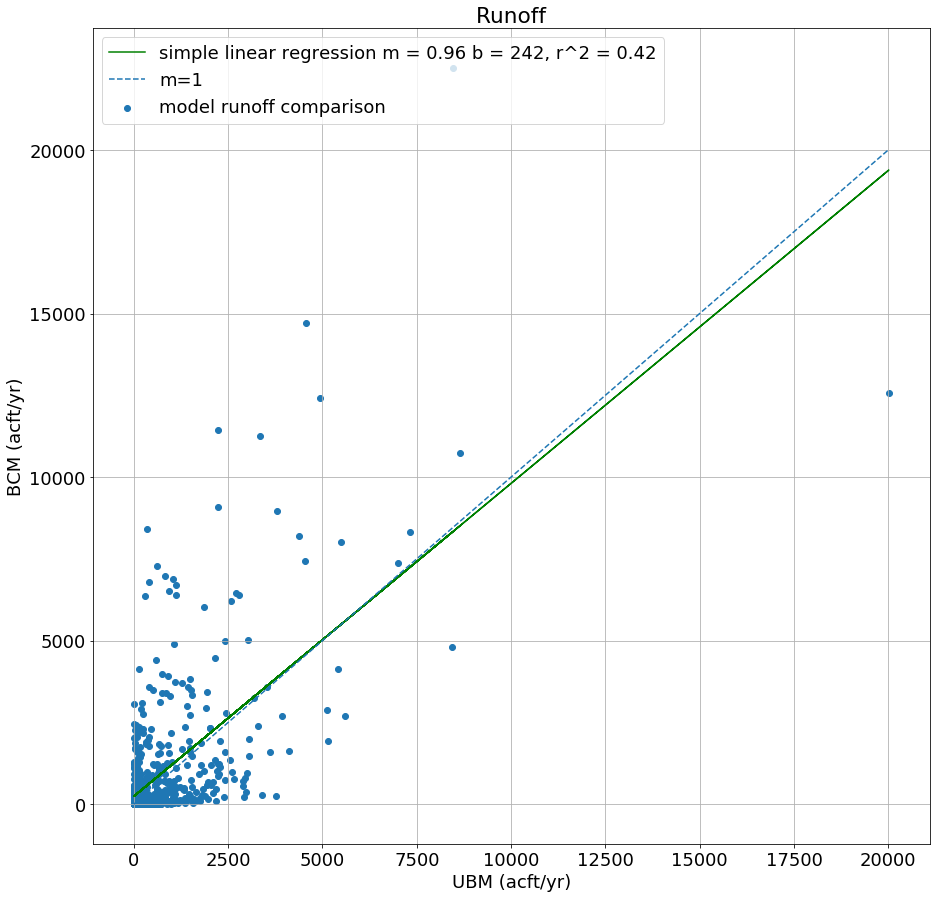

In [70]:
import statsmodels.api as sm

x = BM['ubm_run_acft'].values
Y = BM['BCM_run_acft'].values

X = sm.add_constant(x)
model = sm.OLS(Y,X)
est = model.fit()
const = est.params[0]
slope = est.params[1]

SIZE = 18
plt.rc('font', size=SIZE) 


plt.plot(x, est.predict(X), c='g', label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(slope, const,est.rsquared))
plt.scatter(x,Y, label='model runoff comparison')
x2 = range(int(np.min(x)),int(np.max(x)))
plt.plot(x2,x2,'--', label='m=1')
plt.legend(loc='upper left')
plt.xlabel('UBM (acft/yr)')
plt.ylabel('BCM (acft/yr)')
plt.title('Runoff')
#plt.xlim(-100,10000)
#plt.ylim(-100,8000)
plt.grid()
plt.savefig('U:/GWP/Groundwater/Projects/BCM/Graphs/'+'runoff_bcm_vs_ubm.png')

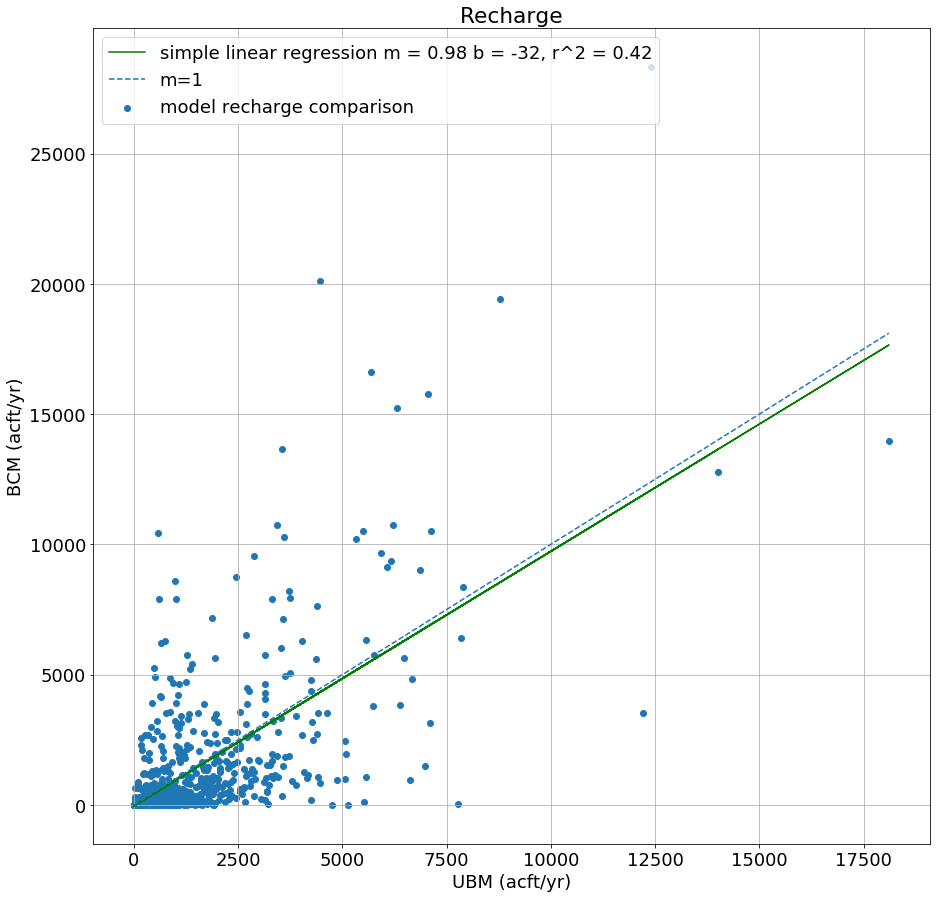

In [71]:
import statsmodels.api as sm

x = BM['ubm_rec_acft'].values
Y = BM['BCM_rec_acft'].values

X = sm.add_constant(x)
model = sm.OLS(Y,X)
est = model.fit()
const = est.params[0]
slope = est.params[1]

SIZE = 18
plt.rc('font', size=SIZE) 

plt.plot(x, est.predict(X), c='g', label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(slope, const,est.rsquared))
plt.scatter(x,Y, label='model recharge comparison')
x2 = range(int(np.min(x)),int(np.max(x)))
plt.plot(x2,x2,'--', label='m=1')

plt.legend(loc='upper left')
plt.xlabel('UBM (acft/yr)')
plt.ylabel('BCM (acft/yr)')
plt.title('Recharge')
#plt.xlim(-100,10000)
#plt.ylim(-100,8000)
plt.grid()
plt.savefig('U:/GWP/Groundwater/Projects/BCM/Graphs/'+'recharge_bcm_vs_ubm.png')

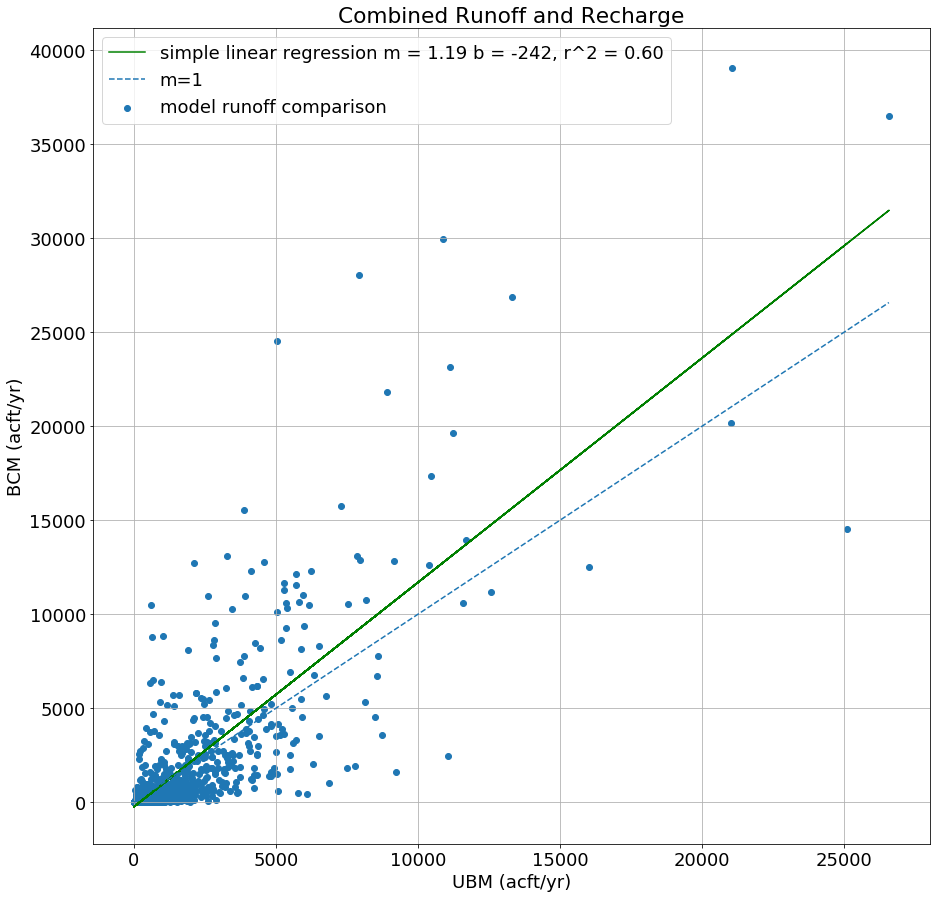

In [72]:
BM['ubm_comb_acft'] = BM['ubm_run_acft'] + BM['ubm_rec_acft']
BM['BCM_comb_acft'] = BM['BCM_run_acft'] + BM['BCM_rec_acft']

x = BM['ubm_comb_acft']
Y = BM['BCM_comb_acft']

X = sm.add_constant(x)
model = sm.OLS(Y,X)
est = model.fit()
const = est.params[0]
slope = est.params[1]

SIZE = 18
plt.rc('font', size=SIZE)   
#matplotlib.rc('pdf', fonttype=42)
plt.plot(x, est.predict(X), c='g', label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(slope, const,est.rsquared))
plt.scatter(x,Y, label='model runoff comparison')
x2 = range(int(np.min(x)),int(np.max(x)))
plt.plot(x2,x2,'--', label='m=1')
plt.legend(loc='upper left')
plt.xlabel('UBM (acft/yr)')
plt.ylabel('BCM (acft/yr)')
#plt.xlim(-100,12000)
#plt.ylim(-100,14000)
plt.title('Combined Runoff and Recharge')
plt.grid()
plt.savefig('U:/GWP/Groundwater/Projects/BCM/Graphs/'+'combined_bcm_vs_ubm.png')

In [63]:
BM.to_clipboard()

In [ ]:
10133980

10217000

10172870

10242000

10234500

10113500

10011500

10155000

10172200

In [ ]:
nw10128500 = wa.nwis("dv",'10128500','sites',startDT='2004-01-01',endDT='2015-01-01')

In [ ]:
nw = wa.nwis("dv",'10133980','sites',startDT='2004-01-01',endDT='2015-01-01')

In [ ]:
nw10128500.data.value.plot()
plt.yscale('log')

In [ ]:
#nw.data.index = nw.data.index.to_datetime()

#nw.data.value.plot()

recess = nw.data[nw.data['value'].diff(2) < 0.0].copy()

recess = recess.resample('1D').mean()
recess.value.plot()
plt.legend()

In [ ]:
recess.groupby(recess.index.month).mean().plot()

In [ ]:
measflow = nw.data
measflow['afm'] = measflow.value * 60.3307
monmeasflow = measflow['afm'].groupby(pd.TimeGrouper('M')).mean().plot()
#monmeasflow['afm']
#rungrp['volume_acft'].plot()
#recgrp['volume_acft'].plot()

In [ ]:
monmeasflow

## Snotel

In [ ]:
# Set environment settings
arcpy.env.workspace = "H:/GIS/Results.gdb/"
arcpy.env.overwriteOutput = True
# Set local variables
memoryFeature = "H:/GIS/UT_BASE.gdb/Snotel"


inRasterList = []

monthRange = [1,12] 
yearRange = [2008,2015]

for y in range(yearRange[0],yearRange[1]+1): #set years converted here
    for m in range(monthRange[0],monthRange[1]+1): #set months converted here
        my = 'asw' + str(y) + str(m).zfill(2)

        arcpy.sa.ExtractValuesToPoints(memoryFeature, my, 'SnotelPoints',"INTERPOLATE", "VALUE_ONLY")
        memoryFeature = "in_memory/myMemoryFeature"
        arcpy.CopyFeatures_management('SnotelPoints', memoryFeature)
        arcpy.AlterField_management(memoryFeature,'RASTERVALU',my,my)
        inPointFeatures = 'SnotelPoints'
        print(my)

## SNODAS Processing

In [ ]:
quer = "SELECT HUC_12,YearMonth,SOURCE,variable,volume_acft FROM ubm.zbudget;"
budg = pd.read_sql_query(sql=quer,con=engine)
budg.ix[budg['SOURCE']=='MODIS','YearMonth'] = budg['YearMonth'].apply(lambda x: x[3:],1)
budg.ix[budg['SOURCE']=='SNODAS','YearMonth'] = budg['YearMonth'].apply(lambda x: x[-9:-3],1)
budg = budg[budg['YearMonth']>200000]
budg['dt'] = pd.to_datetime(budg.YearMonth,errors='coerce',format='%Y%m')
budg.drop(['SOURCE','YearMonth'],axis=1,inplace=True)
budg['HUC_08'] = budg['HUC_12'].apply(lambda x: str(x)[:-4], 1)
prov12 = budg[budg['HUC_12'].isin(['160202030403','160202030402','160202030404'])]
provo = prov12.groupby(['dt','variable']).sum()
provo.reset_index(inplace=True)
provpiv = provo.pivot(index='dt',columns='variable',values='volume_acft')
provpiv['precipitation'] = provpiv['precipitation']/100.0
provpiv = provpiv[provpiv['snow water equivalent']<100000]


In [ ]:
prov12 = budg[budg['HUC_12'].isin(['160202030403','160202030402','160202030404'])]
provo = prov12.groupby(['dt','variable']).sum()
provo.reset_index(inplace=True)
provpiv = provo.pivot(index='dt',columns='variable',values='volume_acft')
provpiv['precipitation'] = provpiv['precipitation']/100.0
provpiv = provpiv[provpiv['snow water equivalent']<100000]


In [ ]:
provpivmo = provpiv.groupby(provpiv.index.month).median()
provpivmo.to_csv()

In [ ]:
provpivmo.sum().to_clipboard(engineroute+"ZoneData.csv")

In [ ]:
provpiv

In [ ]:
provpivmo['total precip'].sum()

In [ ]:
provpiv['precipitation'] = provpiv['precipitation']/100.0
provpiv = provpiv[provpiv['snow water equivalent']<1e7]
provpiv.plot()

In [ ]:
pp

In [ ]:
pp = provpiv.dropna()
x = pp[u'precipitation'].values
y = pp[u'total precip'].values
w = pp.index.to_julian_date()
wa.graphs.scatterColor(x,y,x)

In [ ]:
provo.pivot(index='dt',columns='variable',values='volume_acft')